In [8]:
import os
import re

import pandas as pd
import tensorflow as tf
from tensorflow.keras import utils

data_set = tf.keras.utils.get_file(
    fname = "imdb.tar.gz",
    origin = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract = True)

84131840/84125825 [==============================] - 35s 0us/step


판다스로 데이터를 불러오면 쉽게 분석 과정을 진행할 수 있으나 바로 가져올 수는 없음  
모든 데이터가 txt 파일 형태로 있어서 판다스 데이터프레임을 만들려면 변환 작업이 필요!

In [15]:
def directory_data(directory) : # 각 파일에서 리뷰 텍스트 불러오는 함수
    data = {}
    data["review"] = []
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), "r", encoding = "utf-8") as file :
            data["review"].append(file.read()) # 디렉토리 내 파일을 하나씩 가져와 그 안의 내용을 data["review"] 안에 추가
            
    return pd.DataFrame.from_dict(data) # 딕셔너리를 판다스 데이터 프레임으로 만들어서 반환

In [13]:
def data(directory) : # 폴더 이름을 지정하면 앞에서 설명한 directory_data 함수를 호출하는데 
                      # pos폴더에 접근할지 neg 폴더에 접근할지를 통해 각각의 데이터프레임을 반환받음
    pos_df = directory_data(os.path.join(directory, "pos")) # 긍정 데이터
    neg_df = directory_data(os.path.join(directory, "neg")) # 부정 데이터
    pos_df["sentiment"] = 1
    neg_df["sentiment"] = 0
    
    return pd.concat([pos_df, neg_df])

In [16]:
train_df = data(os.path.join(os.path.dirname(data_set), "aclImdb", "train"))
test_df = data(os.path.join(os.path.dirname(data_set), "aclImdb", "test"))

In [18]:
train_df.head()

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


review와 sentiment가 잘 들어 있는 것을 확인!  
판다스의 데이터프레임으로부터 리뷰문장 리스트를 가져오는 함수를 만들어보자

In [19]:
reviews = list(train_df['review'])

reviews는 각 문장을 리스트로 담고 있다.  
그럼 단어를 토크나이징하고 문장마다 토크나이징 된 단어의 수를 저장하고 그 단어들을 붙여 알파벳의 전체 개수를 저장하는 부분을 만들어 보자.

In [21]:
# 문자열 문장 리스트를 토크나이징
tokenized_reviews = [r.split() for r in reviews]

# 토크나이징된 리스트에 대한 각 길이를 저장 (단어 개수)
review_len_by_token = [len(t) for t in tokenized_reviews]
 
# 토크나이징 된 것을 붙여서 음절의 길이를 저장 (문장길이)
review_len_by_eumjeol = [len(s.replace(' ', '')) for s in reviews]

위와 같이 만든 이유는 문장에 포함된 단어와 알파벳의 개수에 대한 데이터 분석을 수월하게 만들기 위해서!  
먼저 히스토그램으로 문장을 구성하는 단어의 개수와 알파벳 개수를 알아보자

Text(0, 0.5, 'Number of Reviews')

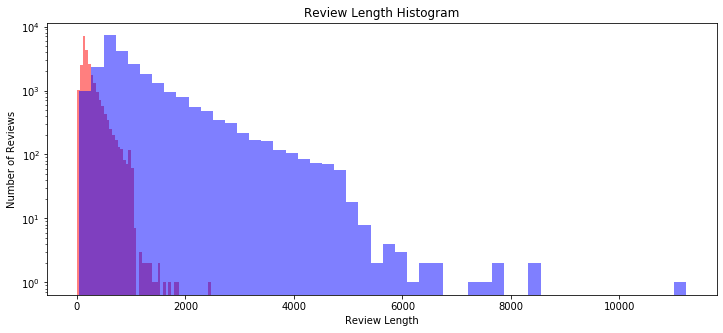

In [22]:
import matplotlib.pyplot as plt

# 그래프에 대한 이미지 크기 선언
# figsize : (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize = (12, 5))
# 히스토그램 선언
# bins : 히스토그램 값에 대한 버킷 범위
# alpha : 그래프 색상 투명도
# color : 그래프 색상
# label : 그래프에 대한 라벨
plt.hist(review_len_by_token, bins = 50, alpha = 0.5, color = 'r', label = 'word')
plt.hist(review_len_by_eumjeol, bins = 50, alpha = 0.5, color = 'b', label = 'alphabet')
plt.yscale('log', nonposy = 'clip')
# 그래프 제목
plt.title('Review Length Histogram')
# 그래프 x축 라벨
plt.xlabel('Review Length')
# 그래프 y축 라벨
plt.ylabel('Number of Reviews')

지금 데이터를 통해 보고자 하는 내용은 문장에 대한 길이 분포!  
빨간색 히스토그램은 단어 개수에 대한 히스토그램, 파란색으느 알파벳 개수의 히스토그램!  
단어 단위와 알파벳의 전체적인 분포를 시각적으로 볼 수 있으며 이상치(outliers) 값을 확인할 수 있음!

In [31]:
import numpy as np

print('문장 최대 길이 : {}'.format(np.max(review_len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(review_len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(review_len_by_token)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(review_len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(review_len_by_token)))
# 사분위의 대한 경우는 0~100 스케일로 돼 있음
print('제1사분위 길이 : {}'.format(np.percentile(review_len_by_token, 25)))
print('제3사분위 길이 : {}'.format(np.percentile(review_len_by_token, 75)))

문장 최대 길이 : 2470
문장 최소 길이 : 10
문장 평균 길이 : 233.79
문장 길이 표준편차 : 173.73
문장 중간 길이 : 174.0
제1사분위 길이 : 127.0
제3사분위 길이 : 284.0


다음으로 박스 플롯으로 데이터를 시각화해 보자.

{'whiskers': [<matplotlib.lines.Line2D at 0x1f723528cc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1f723524648>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f72355ba08>],
 'medians': [<matplotlib.lines.Line2D at 0x1f723521688>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7234c27c8>],
 'means': [<matplotlib.lines.Line2D at 0x1f7237cc848>]}

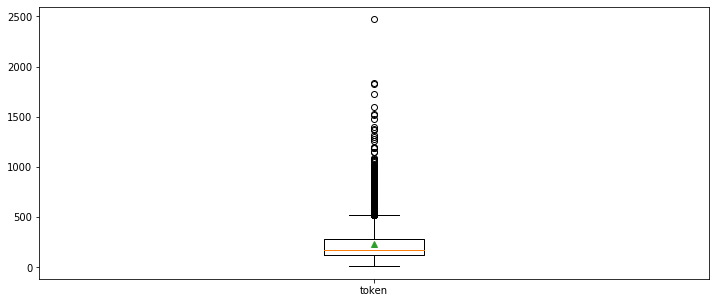

In [32]:
plt.figure(figsize = (12, 5))
# 박스 플롯 생성
# 첫 번째 인자 : 여러 분포에 대한 데이터 리스트를 입력
# labels : 입력한 데이터에 대한 라벨
# showmeans : 평균값을 마크함

plt.boxplot([review_len_by_token],
           labels = ['token'],
           showmeans = True)

- 빨간선 : 중간 값
- 초록삼각형 : 평균값
- 사각형 윗면 : 제3사분위
- 사각형 아랫면 : 제1사분위
- 맨 아래선 : 제 1사분위로부터 3/2 지점
- 맨 윗선 : 제 3사분위로부터 3/2지점
- 맨 윗선 위 : 특이점

{'whiskers': [<matplotlib.lines.Line2D at 0x1f721f53648>,
 'caps': [<matplotlib.lines.Line2D at 0x1f72359f888>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f722425908>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7223fe408>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f721e60f08>],
 'means': [<matplotlib.lines.Line2D at 0x1f72366a988>]}

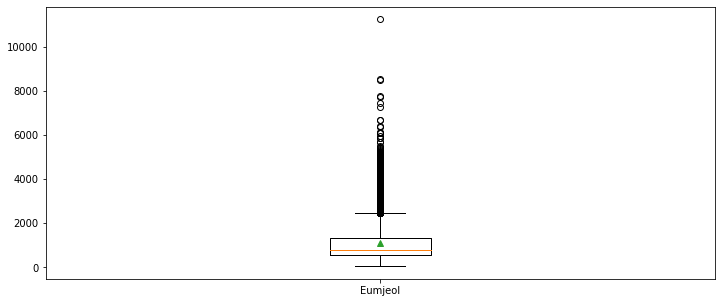

In [33]:
plt.figure(figsize = (12, 5))
plt.boxplot([review_len_by_eumjeol],
           labels = ['Eumjeol'],
           showmeans = True)

이 박스 플롯을 통해서도 이전과 유사하게 이상치가 심한 데이터를 확인할 수 있다.  
이상치가 심하면 데이터의 범위가 너무 넓어 학습이 효율적으로 이뤄지지 않음.  

다음으로 워드클라우드로 데이터를 시각화해보자

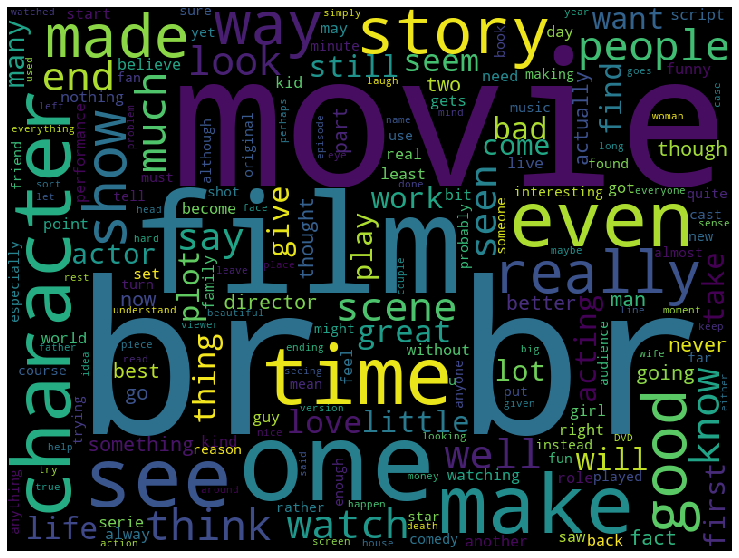

In [34]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 800,
                     height = 600).generate(' '.join(train_df['review']))

plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

마지막으로 긍정 부정의 분포를 확인해보자

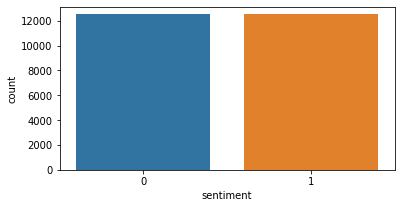

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = train_df['sentiment'].value_counts()
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(6, 3)
sns.countplot(train_df['sentiment'])